In [1]:
from __future__ import print_function

import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,TensorBoard,ReduceLROnPlateau

from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.activations import relu
from tensorflow.keras.regularizers import l2
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K
# from tensorflow.keras.datasets import mnist, cifar10
import tensorflow_addons as tfa

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from scipy.io import loadmat 
import mat73
from datetime import datetime
import ipynbname

print("Packages Loaded")

Packages Loaded


In [2]:
import wandb
from wandb.keras import WandbCallback
time_stamp = datetime.strftime( datetime.now(),'%d_%B_%y_%H%M')
wandb.init(project="my-test-project", entity="ibksolar", name=ipynbname.name()+time_stamp)
 


wandb: Currently logged in as: ibksolar (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [3]:
# base_path = '..\\..\\all_block_data\Dec_Train_block_len_21_011121_2331'
#base_path = '../all_block_data/Old_data/Dec_Train_block_len_21_231121_1531' '../all_block_data\FindPeaks_data\Dec_Train_block_len_21_030122_0614'

base_path = '../../../Python_Env/final_layers_rowblock15_21/filtered_image'

# Confirm path is right...
print(f'{os.path.isdir(base_path)}')

True


In [4]:

raw_data1 = mat73.loadmat(base_path + '/echo_cnn_in_out_jstars.mat')
all_data = raw_data1['echo_cnn_input']
all_target = raw_data1['echo_cnn_target']
all_coords = raw_data1['coords']
echo_idx =raw_data1['orig_echo_idx']


# Set all nan in the data to zeroprint(f'Sum of NaNs in data is {np.sum(np.any(np.isnan(all_data)))}; in target is {np.sum(np.any(np.isnan(all_target)))} ')

print(f'Sum of NaNs in orignally in data is {np.sum(np.any(np.isnan(all_data)))}; in target is {np.sum(np.any(np.isnan(all_target)))} ')
nan_idx = np.isnan(all_data).any(axis =-1)
all_target[nan_idx] = 0
all_data[ np.isnan(all_data) ]= 0

print(f'Sum of NaNs in data after setting all to 0 is {np.sum(np.any(np.isnan(all_data)))}; in target is {np.sum(np.any(np.isnan(all_target)))} ')

Sum of NaNs in orignally in data is 1; in target is 0 
Sum of NaNs in data after setting all to 0 is 0; in target is 0 


In [5]:
# Standardize all_data
standardize = False
if standardize:
    all_data  = ( all_data - all_data.mean() ) / all_data.std()

scale_data = False
if scale_data:
    all_data = 255*all_data

In [6]:
# Truncate data because data after truncate point is notgood for training
truncate_data = False
if truncate_data:    
    echo_idx = np.asarray(echo_idx)
    stop_val = 400

    stop_list, = np.where(echo_idx == stop_val)
    stop_idx = stop_list[-1]

    all_data = all_data[:stop_idx]
    all_target = all_target[:stop_idx]
    all_coords = all_coords[:stop_idx]
    echo_idx = echo_idx[:stop_idx]

    print(f'Data shape {all_data.shape}')
    print(f'Target shape {all_target.shape}')

In [7]:
row_length = 21 # CHANGE HERE <==
col_length = 15

# Check that the dimension of data is correct
if all_data.shape[1] == row_length*col_length:
    print('Dimensions match')
else:
    print(f' Row block length:{row_length} and col length:{col_length} does not match Data dimension:{all_data.shape[1]}') 
        

Dimensions match


In [8]:
# Positional Encoding
time_seq = col_length #5
# all_coords = raw_data1['coords']
all_coord_exp = np.zeros((all_coords.shape[0],time_seq,row_length))

for idx in range(len(all_coords)):
    a,b,c,_ = np.asarray(all_coords[idx],dtype="int")
    if (a%2) == 0: # If row index is even - this isn't implemented well because it requires iterating through individual rows
        all_coord_exp[idx] = np.sin( np.outer( np.arange(c,c+time_seq), pow(10000, (2*np.arange(a,b)/row_length)) ) )
    else:
        all_coord_exp[idx] = np.cos( np.outer( np.arange(c,c+time_seq), pow(10000, (2*np.arange(a,b)/row_length)) ) )

if 0: #truncate_data:
    difficult_coords = all_coord_exp[stop_idx+1:]         
    all_coord_exp = all_coord_exp[:stop_idx]        
   
    
all_coord_exp.shape    

(2094400, 15, 21)

In [9]:
max_class = row_length 

# Highest class is mapped to row_length+1
all_target[all_target == max_class+1 ] = 0


shuffle = 1
if shuffle:
    random.Random(13).shuffle(all_data)
    random.Random(13).shuffle(all_target)
    random.Random(13).shuffle(all_coord_exp)
    # random.Random(1337).shuffle(all_idx)

## Prep data
train_size = int(np.floor(0.8*len(all_target)));
test_size = int(np.round( 0.15* all_data.shape[0] ))
val_size = all_data.shape[0] -train_size - test_size

mid_pt = 8
x_train = all_data[0:train_size,:]
x_train = np.reshape( x_train, (x_train.shape[0],max_class,-1),order ='F' )
#x_train = x_train[:,:,mid_pt-2:mid_pt+3]
# x_train = np.reshape(x_train,(x_train.shape[0],-1))
x_train = np.transpose(x_train,(0,2,1))
coords_train = all_coord_exp[0:train_size,:]


x_test = all_data[train_size:train_size+test_size,:]
x_test = np.reshape( x_test,(x_test.shape[0],max_class,-1), order ='F' )
#x_test = x_test[:,:,mid_pt-2:mid_pt+3]
# x_test = np.reshape(x_test,(x_test.shape[0],-1))
x_test = np.transpose(x_test,(0,2,1))
coords_test = all_coord_exp[train_size:train_size+test_size,:]


x_val = all_data[-val_size:,:]
x_val = np.reshape( x_val,(x_val.shape[0],max_class,-1), order ='F' )
#x_val = x_val[:,:,mid_pt-2:mid_pt+3]
# x_val = np.reshape(x_val,(x_val.shape[0],-1))
x_val = np.transpose(x_val,(0,2,1))
coords_val = all_coord_exp[-val_size:,:]


y_train = all_target[:train_size]
y_test  = all_target[train_size:train_size+test_size]
y_val = all_target[-val_size:]

var_input_shape = x_train.shape[1:] # 240 columns
num_classes = max_class+1 # layers


# Convert labels to categorical orthonormal vectors
y_train_1hot = tf.keras.utils.to_categorical(y_train, num_classes)
y_test_1hot  = tf.keras.utils.to_categorical(y_test, num_classes)

print(f'Shape of X_train:{x_train.shape}  X_test:{x_test.shape}')
print(f'Shape of y_train:{y_train.shape}  y_test:{y_test.shape}')

Shape of X_train:(1675520, 15, 21)  X_test:(314160, 15, 21)
Shape of y_train:(1675520,)  y_test:(314160,)


In [10]:

x_train_new = x_train + coords_train
x_test_new = x_test + coords_test
x_val_new = x_val + coords_val

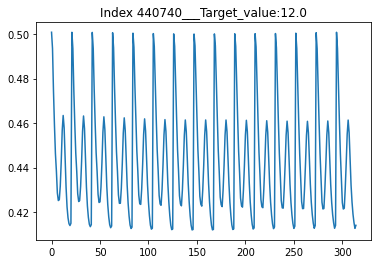

In [11]:
# Visualize some of the input
rand_idx = random.choice( range(1,x_train.shape[0]) )
_ = plt.plot(x_train[rand_idx].flatten())
_ = plt.title(f'Index {rand_idx}___Target_value:{y_train[rand_idx]}' )

In [11]:
# Populate the param log
log ={}
log['Notebook_name'] = ipynbname.name()
log['Uniqueness_of_each_run'] = 'Using FilteredFileterd Old data as training set:Shuffling: Seed 13, Using 15 time_steps_Large batch size(128: Cant do more Memory exhausted)__Adam default optimizer'
log['base_dir'] = base_path
log['Train_shape'] = x_train.shape
log['Output_shape'] = ''
log['num_epochs'] = ''
log['batch_size'] = ''
log['activation_function'] = ''
log['optimizer'] = ''
log['learning_rate'] = ''
log['loss_finction'] = ''
log['accuracy'] = []
log['loss'] = []
log['stop_time'] = ''
log['Model_config'] = ''
log['Performance_on_test_set'] = ''
log['output_path'] = ''  # output: where the trained model is saved
log['shuffle'] = shuffle
log['run_completion_comment'] = '' # Comment on training and probably evaluation too

from model_hyper_param_log import create_log_entry,update_log_entry
if "log_idx" in globals():
    log["S_N"] = log_idx
log_idx = create_log_entry('../testing_sheet2.xlsx', log)

Could not get file name: auto-generating name
Activation_function not in workspace
loss_function not in workspace
Accuracy_per_epoch not in workspace
Loss_per_epoch not in workspace
Stop_time not in workspace
extras  is not in workspace
Current run hyper_params are dict_keys(['S_N', 'Start_time', 'NoteBook_name', 'Uniqueness_of_each_run', 'Base_dir', 'Train_shape', 'Output_shape', 'num_epochs', 'Activation_function', 'optimizer', 'learning_rate', 'loss_function', 'Accuracy_per_epoch', 'Loss_per_epoch', 'Stop_time', 'Model_config', 'Performance_on_test_set', 'output_path', 'shuffle', 'Computer_name', 'extras']):dict_values([33, '02_February_22_1144', 'NewAttention_RowBlock_Dec', 'Using FilteredFileterd Old data as training set:Shuffling: Seed 13, Using 15 time_steps_Large batch size(128: Cant do more Memory exhausted)__Adam default optimizer', '../../../Python_Env/final_layers_rowblock15_21/filtered_image', (1675520, 15, 21), '', '', '', '', '', '', '', '', '', '', '', '', 1, 'AQ-98JH67

In [13]:
# TRY KERAS TUNER
if 0:
    # ResNet params
    resnet_heads = 15

    # Attention params
    num_epochs = 3
    batch_size = 64
    nodes = 512 #512
    learning_rate = 3e-3

    head_size = 256 # 256,64
    num_heads = 8
    ff_dim= 16
    num_transformer_blocks= 15
    mlp_units=[nodes]*2,  # 128
    mlp_dropout=0.3,     #0.4
    dropout=0.2    


    def model_builder(
        input_shape,
        hp,
        head_size = head_size,
        num_heads = num_heads,
        ff_dim = ff_dim,
        num_transformer_blocks = num_transformer_blocks,
        mlp_units = mlp_units,    
        dropout=0,
        mlp_dropout=0,    
    ):
        inputs = tf.keras.Input(shape=input_shape)
        # x = inputs
        x =   layers.Conv2D(filters=64, kernel_size=3, padding="same")(inputs)

        for _ in range(resnet_heads):
            x = ResNetBlock(x)

        x = tf.reduce_sum(x,axis=-1)

        for _ in range(num_transformer_blocks):
            x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

        # Pool or average
        # x = layers.GlobalAveragePooling1D()(x)#data_format="channels_first"    
        # x = layers.Flatten()(x)

        for dim in mlp_units:
            x = layers.Dense(dim, activation="relu")(x)
            x = layers.Dropout(mlp_dropout)(x)

        x = layers.Flatten()(x)
        x = layers.Dense(64, activation="softmax")(x)
        x = layers.Dropout(mlp_dropout)(x)
        outputs = layers.Dense(num_classes, activation="softmax")(x)

        # Tune the learning rate for the optimizer
        # Choose an optimal value from 0.01, 0.001, or 0.0001

        hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=['accuracy']) 
        return tf.keras.Model(inputs, outputs)

    tuner = kt.Hyperband(model_builder,
                         objective='val_accuracy',
                         max_epochs=10,
                         factor=3,)

    stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

    tuner.search(x_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

    # Get the optimal hyperparameters
    best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

    print(f"""
    The hyperparameter search is complete. The optimal number of units in the first densely-connected
    layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
    is {best_hps.get('learning_rate')}.
    """)

In [ ]:

def ResNetBlock(x,nodes):
    #x =   layers.Conv2D(filters=64, kernel_size=3, padding="same")(x) #input_layer
    conv1 = layers.Conv2D(filters=nodes, kernel_size=3, padding="same")(x) # input_layer, Conv1D
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.ReLU()(conv1)

    conv2 = layers.Conv2D(filters=nodes, kernel_size=3, padding="same")(conv1)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.ReLU()(conv2)

    conv3 = layers.Conv2D(filters=nodes, kernel_size=3, padding="same")(conv2)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.ReLU()(conv3)
    
#     conv4 = layers.Conv2D(filters=nodes, kernel_size=3, padding="same")(conv3)
#     conv4 = layers.BatchNormalization()(conv4)
#     conv4 = layers.ReLU()(conv4)
    
#     conv5 = layers.Conv2D(filters=nodes, kernel_size=3, padding="same")(conv4)
#     conv5 = layers.BatchNormalization()(conv5)
#     conv5 = layers.ReLU()(conv5)
    
    conv3 = layers.add([x,conv3])
    x = layers.ReLU()(conv3) # Overwrite x
    
    return x

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    conv_feed_fwd = False
    
    # Attention and Normalization
    inputs2 = layers.LayerNormalization(epsilon=1e-6)(inputs)
    
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs2, inputs2)
    
    x = x + inputs # Skip connection
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x
    #x = layers.Dropout(dropout)(x)       

    # Feed Forward Part
    if conv_feed_fwd:
        x = layers.Conv2D(filters=ff_dim, kernel_size=(5,3),padding="same", activation="relu")(res)
        x = layers.Dropout(dropout)(x)
        x = layers.Conv2D(filters=ff_dim, kernel_size=(5,3),padding="same", activation="relu")(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x)
    else:
        for units in [ff_dim*2, ff_dim]: # Bad implementation: This has to be 64
            x = layers.Dense(units, activation=tf.nn.gelu)(x)
            x = layers.Dropout(0.1)(x)
    return x + res

def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    nodes,
    dropout=0,
    mlp_dropout=0,    
):
    inputs = tf.keras.Input(shape=input_shape)
    x = inputs
    #x =   layers.Conv2D(filters=64, kernel_size=3, padding="same")(inputs)
    
    for _ in range(resnet_heads):
        x = ResNetBlock(x,ff_dim)
     
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)   

    # x = tf.reduce_sum(x,axis=-1)
    # Pool or average
    # x = layers.GlobalAveragePooling1D()(x)#data_format="channels_first"    
    # x = layers.Flatten()(x)   
    
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(dropout)(x)
    
    for dim in mlp_units:
        x = layers.Dense(dim, activation=tf.nn.gelu)(x) #"relu"
        x = layers.Dropout(mlp_dropout)(x)   
    
    # x = tf.reduce_sum(x,axis=-1) # Add in "filters" dimension to speed up?
    #x = layers.LayerNormalization(epsilon=1e-6)(x) 
    #x = layers.Dense(64, activation="relu")(x) #"relu"
    
    x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    return tf.keras.Model(inputs, outputs)


input_shape = (x_train.shape[1:]) + (1,) #input_shape = (21,5,) #x_train.shape[2]

# ResNet params
resnet_heads = 10

# Checkpoint path
base_path2 = r'Y:\ibikunle\Python_Project\Fall_2021\all_block_data\PulsedTrainTest'

# Attention params
num_epochs = 150
batch_size = 128
nodes = 64 #512
learning_rate = 5e-2

head_size = 64 # 256,64
num_heads = 4
ff_dim= 64
num_transformer_blocks= 8
mlp_units= [512,1024]  # 128,512
mlp_dropout=0.1    #0.4
dropout=0.1          #0.25

model = build_model(input_shape,head_size=head_size,num_heads=num_heads,ff_dim=ff_dim,
                    num_transformer_blocks = num_transformer_blocks,
                    mlp_units=mlp_units, nodes=nodes, 
                    mlp_dropout=mlp_dropout, dropout=dropout)

wandb.config = {
  "learning_rate": "learning_rate",
  "epochs": num_epochs, 
  "batch_size": batch_size,
  "nodes": nodes,
  "row_length":row_length,
  "base_path":base_path,
  "head_size":head_size, "num_heads":num_heads,
  "ff_dim":ff_dim, "num_transformer_blocks":num_transformer_blocks,
  "mlp_units":mlp_units, "mlp_dropout":mlp_dropout,
  "dropout":dropout
}


# Poly Rate scheduler
starter_learning_rate = 0.001
end_learning_rate = 0.0001
decay_steps = 1000
learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(
    starter_learning_rate,
    decay_steps,
    end_learning_rate,
    power=0.25)

# Callbacks
callbacks = [
    ModelCheckpoint(base_path2+'/'+ipynbname.name()+"/best_model.h5", save_best_only=True, monitor="val_loss"),
    ReduceLROnPlateau(monitor="val_loss", factor=0.05, patience=10, min_lr=0.0001),
    #EarlyStopping(monitor="val_loss", patience=25, verbose=1), 
    WandbCallback()
]

# Trying different optimizers
opt1 = tf.keras.optimizers.RMSprop(learning_rate=learning_rate,rho=0.9,momentum=0.9, epsilon=1e-07,centered=True,name="RMSprop")
opt2 = tf.keras.optimizers.Adam(learning_rate=learning_rate,amsgrad=True)
opt3 = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True, name="SGD")
opt4 = tfa.optimizers.AdamW(weight_decay = 0.0001, learning_rate=learning_rate,)

poly_rate = tf.keras.optimizers.SGD(learning_rate = learning_rate_fn)
poly_rate2 = tf.keras.optimizers.Adam(learning_rate = learning_rate_fn)
top_K = 3

start_time = datetime.strftime( datetime.now(),'%d_%B_%y_%H%M')
print(f'Training start time:{start_time}')

# model.compile( optimizer = opt, loss= 'categorical_crossentropy', metrics=['accuracy',tf.keras.metrics.TopKCategoricalAccuracy(top_K, name="top-3-accuracy")])  #label_smoothing=0.05, tf.keras.losses.KLDivergence()
#model.compile( optimizer=opt1,loss="sparse_categorical_crossentropy" , metrics=["sparse_categorical_accuracy"],) #"sparse_categorical_crossentropy" , sparse_categorical_accuracy", tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.3)
model.compile( optimizer = opt4, loss="categorical_crossentropy" , metrics=['accuracy',tf.keras.metrics.TopKCategoricalAccuracy(top_K, name="top-3-accuracy")],) # sparse_categorical_accuracy", tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.3)
#Adam(amsgrad=True), loss="categorical_crossentropy"  optimizer=opt2,loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2)

history = model.fit(x_train, y_train_1hot,
          epochs= num_epochs, 
          batch_size= batch_size, 
          validation_data=(x_test, y_test_1hot),
         callbacks=callbacks) #mcp_save, callbacks=[reduce_lr_loss]

# Update manual log file
params_to_be_updated = update_log_entry('../testing_sheet2.xlsx', log_idx, model, history)

# Update model with the best from Callbacks
model = tf.keras.models.load_model(base_path2+'/'+ipynbname.name()+"/best_model.h5")

end_time = datetime.strftime( datetime.now(),'%d_%B_%y_%H_%M')
print(f'End time {end_time}')

# Previous accuracy before using Findpeaks data was 12%

Training start time:06_February_22_2213
Epoch 1/150
13090/13090 [==============================] - 4302s 328ms/step - loss: 20.3188 - accuracy: 0.1166 - top-3-accuracy: 0.3204 - val_loss: 2.6309 - val_accuracy: 0.1342 - val_top-3-accuracy: 0.3304
Epoch 2/150
13090/13090 [==============================] - 4290s 328ms/step - loss: 239.4211 - accuracy: 0.1123 - top-3-accuracy: 0.3172 - val_loss: 2.6118 - val_accuracy: 0.0946 - val_top-3-accuracy: 0.3331
Epoch 3/150
13090/13090 [==============================] - 4271s 326ms/step - loss: 2.6231 - accuracy: 0.1158 - top-3-accuracy: 0.3219 - val_loss: 2.6123 - val_accuracy: 0.1342 - val_top-3-accuracy: 0.3304
Epoch 4/150
13090/13090 [==============================] - 4273s 326ms/step - loss: 2.6137 - accuracy: 0.1192 - top-3-accuracy: 0.3239 - val_loss: 2.6002 - val_accuracy: 0.1342 - val_top-3-accuracy: 0.3403
Epoch 5/150
13090/13090 [==============================] - 4280s 327ms/step - loss: 265.0177 - accuracy: 0.1188 - top-3-accuracy: 0.3

In [ ]:
history2 = model.fit(x_train, y_train_1hot,
      epochs= 350, 
      batch_size= batch_size, 
      validation_data=(x_test, y_test_1hot),
     callbacks=callbacks)

Epoch 1/350
4049/4049 [==============================] - 780s 192ms/step - loss: 2.0241 - accuracy: 0.3702 - top-3-accuracy: 0.6095 - val_loss: 1.3898 - val_accuracy: 0.6444 - val_top-3-accuracy: 0.8642
Epoch 2/350
4049/4049 [==============================] - 776s 192ms/step - loss: 2.0203 - accuracy: 0.3735 - top-3-accuracy: 0.6107 - val_loss: 1.3472 - val_accuracy: 0.6591 - val_top-3-accuracy: 0.8709
Epoch 3/350
4049/4049 [==============================] - 773s 191ms/step - loss: 2.0225 - accuracy: 0.3722 - top-3-accuracy: 0.6096 - val_loss: 1.3711 - val_accuracy: 0.6602 - val_top-3-accuracy: 0.8686
Epoch 4/350
4049/4049 [==============================] - 776s 192ms/step - loss: 2.0118 - accuracy: 0.3789 - top-3-accuracy: 0.6129 - val_loss: 1.3100 - val_accuracy: 0.6737 - val_top-3-accuracy: 0.8754
Epoch 5/350
4049/4049 [==============================] - 775s 191ms/step - loss: 2.0063 - accuracy: 0.3823 - top-3-accuracy: 0.6139 - val_loss: 1.3071 - val_accuracy: 0.6761 - val_top-3-ac

In [44]:
log['Uniqueness_of_each_run'] = 'Used Amsgrad and default learning rate to train. Removed label smoothing too'
run_completion_comment = f'Training on first 400 echos: Training looks so good! 98% acc. Need to test for overfitting'
if "log_idx" in globals():
    log["S_N"] = log_idx
    log['run_completion_comment'] = run_completion_comment
    log_idx = create_log_entry('../testing_sheet2.xlsx', log)

Could not get file name: auto-generating name
Activation_function not in workspace
extras  is not in workspace
Current run hyper_params are dict_keys(['S_N', 'Start_time', 'NoteBook_name', 'Uniqueness_of_each_run', 'Base_dir', 'Train_shape', 'Output_shape', 'num_epochs', 'Activation_function', 'optimizer', 'learning_rate', 'loss_function', 'Accuracy_per_epoch', 'Loss_per_epoch', 'Stop_time', 'Model_config', 'Performance_on_test_set', 'output_path', 'shuffle', 'Computer_name', 'extras']):dict_values([16, '09_January_22_1705', 'NewAttention_RowBlock_Dec', 'Used Amsgrad and default learning rate to train. Removed label smoothing too', '../all_block_data\\FindPeaks_data\\Dec_Train_block_len_21_030122_0614', (518245, 15, 21), '', '', '', '', '', '', [], [], '', '', '', '', 0, 'AQ-LHJBMA1', ''])
Fields to be updated include: ['Activation_function', 'learning_rate', 'loss_function', 'Accuracy_per_epoch', 'Loss_per_epoch', 'Stop_time', 'Model_config', 'Performance_on_test_set', 'extras']


In [47]:

import random
check_start = random.randint(0,len(x_val))

print(f'Check start idx: {check_start}')
[(np.argmax(y_val[idx]), np.argmax(model.predict(np.expand_dims(x_val[idx],axis=0))) ) for idx in range(check_start,check_start+20) ]


Check start idx: 11343


[(12, 7),
 (12, 7),
 (12, 7),
 (12, 7),
 (12, 7),
 (12, 7),
 (12, 7),
 (12, 7),
 (12, 7),
 (12, 7),
 (12, 7),
 (12, 7),
 (12, 7),
 (12, 7),
 (12, 7),
 (12, 7),
 (12, 7),
 (12, 7),
 (12, 7),
 (12, 7)]

In [45]:
y_val = tf.keras.utils.to_categorical(y_val, num_classes)
_, accuracy,top_5_accuracy = model.evaluate(x_val, y_val)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
# print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")


model.save(f'{base_path}//{ipynbname.name()}//{time_stamp}_Acc_{accuracy}_{row_length}x{col_length}.h5')

1013/1013 [==============================] - 27s 26ms/step - loss: 14.9815 - accuracy: 0.0233 - top-3-accuracy: 0.1946
Test accuracy: 2.33%


In [ ]:
# Train further
if accuracy < 0.7:
    history = model.fit(x_train, y_train,
          epochs= 20, 
          batch_size= batch_size, 
          validation_data=(x_test, y_test),
         callbacks=callbacks) #mcp_save, callbacks=[reduce_lr_loss]